In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Preprocessing

In [2]:
path = "/Users/leoware/PycharmProjects/Bus Simulation/data/sim_2021-09-23_18:53:01.072561/log_15_0__2021-09-23 18:53:01.073343.csv"

df_raw = pd.read_csv(path)
for col in ["object_type", "action", "status"]:
    df_raw[col] = df_raw[col].astype("category")

df_raw["data"] = pd.to_numeric(df_raw["data"].replace("None", ""))

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23078 entries, 0 to 23077
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   event_id     23078 non-null  int64   
 1   time         23078 non-null  float64 
 2   object_type  23078 non-null  category
 3   object_id    23078 non-null  int64   
 4   action       23078 non-null  category
 5   status       23078 non-null  category
 6   data         944 non-null    float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 789.5 KB


In [3]:
# there are two copies of each event, one logged on dispath and one logged on completion
# we want to merge these together
dispatched = (df_raw[df_raw["status"] == "DISPATCHED"]
    .rename(columns={"time": "dispatch_time"})
    .drop("status", axis=1))

# just take event_id and time from this one
finished = (df_raw[df_raw["status"] == "FINISHED"][["event_id", "time"]]
    .rename(columns={"time": "finish_time"}))

# merge them back together to get start and end times for every event
df = (pd.merge(dispatched, finished, how="left", on="event_id")
            [["event_id", "action", "object_type", "object_id", "dispatch_time", "finish_time", "data"]])

# drop events that were in progress when the sim ended
df = df[df["finish_time"].notna()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11053 entries, 0 to 12022
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   event_id       11053 non-null  int64   
 1   action         11053 non-null  category
 2   object_type    11053 non-null  category
 3   object_id      11053 non-null  int64   
 4   dispatch_time  11053 non-null  float64 
 5   finish_time    11053 non-null  float64 
 6   data           464 non-null    float64 
dtypes: category(2), float64(3), int64(2)
memory usage: 540.2 KB


In [4]:
df[(df['object_type'] == 'Passenger') & (df['object_id'] == 3)]

,event_id,action,object_type,object_id,dispatch_time,finish_time,data
51,1051,JOIN_QUEUE,Passenger,3,0.543868,10.543868,NaN
82,1082,PASSENGER_EMBARK,Passenger,3,2.544563,2.544563,NaN
478,1478,PASSENGER_DISEMBARK,Passenger,3,14.350897,14.470770,13.926902
485,1485,PASSENGER_DISEMBARK,Passenger,3,14.501277,14.587885,14.044018


# Event Durations

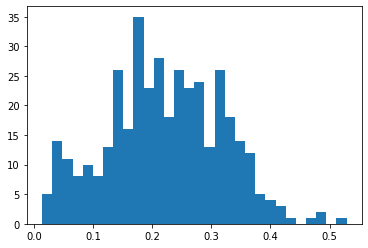

In [5]:
df['duration'] = df['finish_time'] - df['dispatch_time']
plt.hist(df[df["action"] == "PASSENGER_DISEMBARK"]['duration'], bins=30)
plt.show()

# Transit Times

/var/folders/7_/t6r6q2tn0mv_rnygf2k3bbtm0000gn/T/ipykernel_53756/4037019653.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


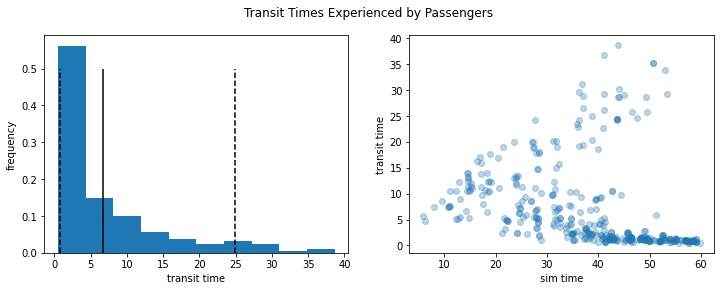

In [6]:
def number_over_time(X, Y, y_label):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

    ax1.hist(Y, weights=np.ones_like(Y)/Y.size)
    ax1.set_xlabel(y_label)
    ax1.set_ylabel("frequency")

    mx = 0.5
    ax1.vlines(Y.mean(), 0, mx, colors="black")
    ax1.vlines(np.percentile(Y, 5), 0, mx, colors="black", linestyles="dashed")
    ax1.vlines(np.percentile(Y, 95), 0, mx, colors="black", linestyles="dashed")

    ax2.scatter(X, Y, alpha=0.3)
    ax2.set_xlabel("sim time")
    ax2.set_ylabel(y_label)

    return fig

disembarks = df[df["action"] == "PASSENGER_DISEMBARK"]
fig = number_over_time(disembarks["finish_time"], disembarks["data"], "transit time")
fig.suptitle("Transit Times Experienced by Passengers")
fig.show()

# Queue Lengths

/var/folders/7_/t6r6q2tn0mv_rnygf2k3bbtm0000gn/T/ipykernel_53756/1892597517.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


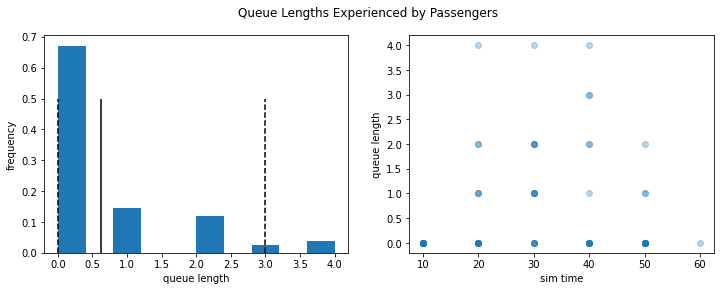

In [7]:
queue_len = df[df["action"] == "REPORT_QUEUE_LENGTH"]
fig = number_over_time(queue_len["finish_time"], queue_len["data"], "queue length")
fig.suptitle("Queue Lengths Experienced by Passengers")
fig.show()

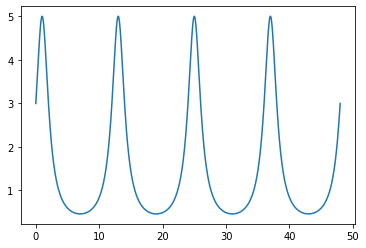

In [8]:
from math import pi

X = np.linspace(0, 48, 1000)
Y = 1/(1.2 + np.cos(pi * (X - 7) / 6))
plt.plot(X, Y)